## Homework 3

Implementation of gradient descent with a fixed step size for a quadratic function (defined in quadfun).

In [37]:
import numpy as np

#Runs Gradient Descent with a fixed step size (alpha) for at most max_iter or until norm(gradient) <= epsilon
#x0 defines the starting point and fun is used to compute the gradient (should be given as a lambda function, see below)
#Outputs a vector of the iterates (x_all), the vector of the norm of the gradient at each step (g_all), and the number of
#iterations (i)
def gradient_descent_fixed(x0, fun, alpha, epsilon, max_iter):
    #Set current x to initial x
    x = x0

    #Compute the gradient using fun (mode = 2)
    gradient = fun(x, 2)
    #Calculate the norm of the gradient
    normg = np.linalg.norm(gradient)

    #Initialize the vectors to be output
    x_all = [x0]
    g_all = [normg]
    i = 0
    
    #Run until we have performed all iterations or found a point with sufficiently small norm
    while normg > epsilon and i < max_iter:
        #Gradient descent update
        x = x - alpha * gradient
        i += 1

        #Compute gradient at new point
        gradient = fun(x, 2)
        normg = np.linalg.norm(gradient)

        #Record the new point for output
        x_all.append(x)
        g_all.append(normg)
    return x_all, g_all, i

In [38]:
#Computes the function value (mode = 1) or gradient (mode = 2) of a quadratic function of the form
#(1/2)*x^T A x + b^T x
def quadfun(x, mode, A, b):
    if mode == 1:
        #Compute the function value
        return 0.5 * np.dot(x, np.dot(A, x)) + np.dot(b, x),
    elif mode == 2:
        #Compute the gradient
        return np.dot(A, x) + b
    else:
        raise ValueError('mode must be either 1 or 2')

### Question 2 Part A

Below is some starting code for part A. It generates a random 100x100 symmetric matrix $A$ with eigenvalues between 10 and 0.01 that is used to define the quadratic function $\frac12x^T A x$. The code runs gradient descent (from a random starting point) with a fixed step size of 1/L for at most 1000 iterations or until the norm of the gradient is below 10^-4. You should implement a backtracking line search gradient descent method and compare it to the fixed step size, following the settings in the homework PDF. You should observe that the fixed step size method is very sensitive to the choice of the step size, while the line search methods perform nearly the same with different values of $c$. Example plotting code is given in the following block.

In [39]:
m = 0.01; L=10; kappa = L/m

#Code to create matrix A
# Generate a random matrix of size (n, n)
n = 100
randmat = np.random.randn(n, n)

# Perform QR factorization
Q, R = np.linalg.qr(randmat)

D = np.random.rand(n); D = 10**D; Dmin = min(D); Dmax = max(D)

D = (D-Dmin)/(Dmax-Dmin)
D = m + D*(L-m)
A = np.transpose(Q)*np.diag(D)*Q

#b is the zero vector
b = np.array(np.zeros(n))

#Random starting point
x0 = np.random.randn(n)

max_iter = 1000
epsilon = 10**-3
alpha = 1/L

#The lambda function notation is a bit of a python specific feature. It passes in the argument as a function to be used in gradient_descent_fixed
#that takes the parameters x and y when calling quadfun (the current point x and the desired computation mode). If you
#use this same setup, inside the gradient_descent_fixed function, calling fun(myx,1) computes the function value at the
#point myx and fun(myx,2) computes the gradient at the point myx. This allows for us to write generic gradient descent
#code that can be used for any function, so long as we pass it in in this way.
x_fixed_L, g_fixed_L, i_fixed_L = gradient_descent_fixed(x0, lambda x, y: quadfun(x, y, A, b), alpha, epsilon, max_iter)

Plot the result of the above code with a logarithmic y-axis.

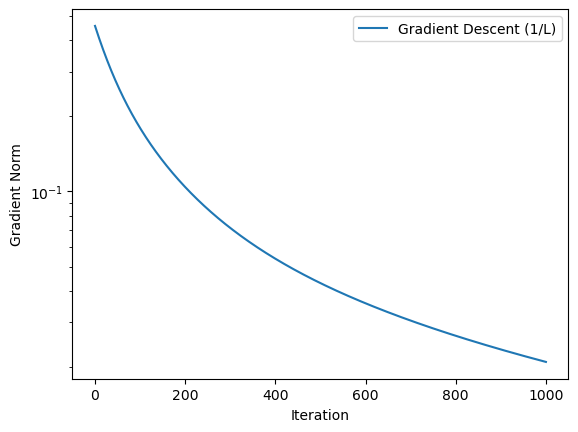

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.semilogy(g_fixed_L, label='Gradient Descent (1/L)')
ax.set_xlabel('Iteration')
ax.set_ylabel('Gradient Norm')
ax.legend()
plt.show()

#### Question 2 Part A Solution

In [41]:
def backtracking_line_search(
    xk, fun, alpha0,
    c, rho=0.5  # backtracking line search hyperparameters
):
    """
    :param alpha0: initial step size
    :param c:
    :param rho: factor to decay current step size
    :return: step size (alpha) such that function (fun) satisfies the lipschitz continuous gradient upper bound when taking a step in given direction (dk) from the current interation (xk).
    """

    # initialize function value and gradient at the current iteration xk
    value_xk = fun(xk, 1)
    dk = -1 * fun(xk, 2)
    dk_norm = np.linalg.norm(dk)

    alpha = alpha0
    while fun(xk + alpha * dk, 1) > value_xk + c * alpha * dk_norm:
        alpha *= rho

    return alpha


def gradient_descent_line_search(
    x0, fun,
    alpha0, c, rho=0.5,
    epsilon=10e-3, max_iter=1000  # termination conditions on vanishing gradients (epsilon) or iterations (max_iter)
):
    """
    :return: gradient descent iterations (x_all) and gradient norms (g_all) from function (fun) and initialized point (x0) with a backtracking line search from (alpha0) with given hyperparameters (c and rho)
    """

    # keep track of the iterations taken in addition to the entire sequence of updates (x_all) and gradient size (g_all)
    T = 0
    x_all, g_all = [], []

    # compute function value and gradient/descent direction (d) at the initial point
    x = x0
    d = fun(x, 2)
    d_norm = np.linalg.norm(d)
    g_all.append(d_norm)

    # terminate if gradient (d) has sufficiently vanished or iterations exceed cap (max_iter)
    while (
        d_norm > epsilon
        and T < max_iter
    ):

        # compute line search using steepest descent
        alpha = backtracking_line_search(
            x, fun,
            alpha0, c, rho
        )

        # perform gradient descent update
        T += 1
        x = x - alpha * d
        x_all.append(x)

        # compute gradient at next iteration
        d = fun(x, 2)
        d_norm = np.linalg.norm(d)
        g_all.append(d_norm)

    return x_all, g_all, T



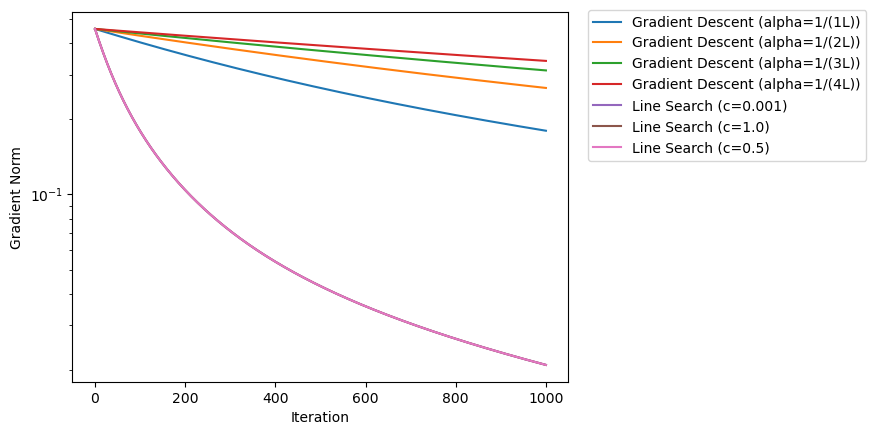

In [42]:
# initialize output plot
plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')

for i in range(4):

    # perform GD w/ backtracking line search
    alpha0 = alpha / ((i + 1) * L)
    _, g_fixed, _ = gradient_descent_fixed(
        x0, lambda x, y: quadfun(x, y, A, b),
        alpha0,
        epsilon, max_iter
    )

    # make a plot w/ log scaling on the y-axis
    plt.semilogy(g_fixed, label=f'Gradient Descent (alpha=1/({i + 1}L))')

# iterate c's of interest for line search hyperparameter
cs = [10e-4, 10e-1, 0.5]
for c in cs:

    # perform GD w/ backtracking line search
    _, g_line_search, _ = gradient_descent_line_search(
        x0, lambda x, y: quadfun(x, y, A, b),
        alpha, c, rho=0.5,
        epsilon=epsilon, max_iter=max_iter
    )

    # make a plot with log scaling on the y-axis
    plt.semilogy(g_line_search, label=f'Line Search (c={c})')

plt.legend(bbox_to_anchor=(1.025, 1.025), loc='upper left')
plt.show()

### Question 2 Part B

Below is some starting code for part B. It generates a random 100x100 symmetric matrix $A$ with eigenvalues between 1 and 0.01 that is used to define the quadratic function $\frac12x^T A x$ (this question uses a slightly different eigenvalue distribution). Now, you should implement the heavy ball and Nesterov's accelerated gradient algorithm and compare them to gradient descent using the parameters described in the homework PDF.

In [43]:
m = 0.01; L=1; kappa = L/m

#Code to create matrix A
# Generate a random matrix of size (n, n)
n = 100
randmat = np.random.randn(n, n)

# Perform QR factorization
Q, R = np.linalg.qr(randmat)

D = np.random.rand(n); D = 10**D; Dmin = min(D); Dmax = max(D)

D = (D-Dmin)/(Dmax-Dmin)
D = m + D*(L-m)
A = np.transpose(Q)*np.diag(D)*Q

#b is the zero vector
b = np.array(np.zeros(n))

#Random starting point
x0 = np.random.randn(n)

max_iter = 10000
epsilon = 10**-3

alpha = 1/L
x_fixed_L, g_fixed_L, i_fixed_L = gradient_descent_fixed(x0, lambda x, y: quadfun(x, y, A, b), alpha, epsilon, max_iter)

#### Question 2 Part B Solution

In [44]:
def gradient_descent_heavy_ball(
    x0, fun,
    alpha, beta,
    epsilon=10e-3, max_iter=1000  # termination conditions on vanishing gradients (epsilon) or iterations (max_iter)
):
    """
    :return: gradient descent iterations (x_all) and gradient norms (g_all) from function (fun) and initialized point (x0) with heavy ball momentum controlled by hyperparameter (beta)
    """

    # keep track of the iterations taken in addition to the entire sequence of updates (x_all) and gradient size (g_all)
    T = 0
    x_all, g_all = [], []

    # compute function value and gradient/descent direction (d) at the initial point
    x = x0
    x_all.append(x)

    d = fun(x, 2)
    d_norm = np.linalg.norm(d)
    g_all.append(d_norm)

    # terminate if gradient (d) has sufficiently vanished or iterations exceed cap (max_iter)
    while (
        d_norm > epsilon
        and T < max_iter
    ):

        # compute momentum
        momentum = (
            beta * (x - x_all[-2]) if len(x_all) > 2
            else 0
        )

        # perform gradient descent update w/ momentum
        T += 1
        x = x - alpha * d
        x = x + momentum
        x_all.append(x)

        # compute gradient at next iteration
        d = fun(x, 2)
        d_norm = np.linalg.norm(d)
        g_all.append(d_norm)

    return x_all, g_all, T


def gradient_descent_nesterov(
    x0, fun,
    alpha, beta,
    epsilon=10e-3, max_iter=1000  # termination conditions on vanishing gradients (epsilon) or iterations (max_iter)
):
    """
    :return: gradient descent iterations (x_all) and gradient norms (g_all) from function (fun) and initialized point (x0) with nesterov momentum controlled by hyperparameter (beta)
    """

    # keep track of the iterations taken in addition to the entire sequence of updates (x_all) and gradient size (g_all)
    T = 0
    x_all, g_all = [], []

    # compute function value and gradient/descent direction (d) at the initial point
    x = x0
    x_all.append(x)

    d = fun(x, 2)
    d_norm = np.linalg.norm(d)
    g_all.append(d_norm)

    # terminate if gradient (d) has sufficiently vanished or iterations exceed cap (max_iter)
    while (
        d_norm > epsilon
        and T < max_iter
    ):

        # compute momentum
        momentum = (
            beta * (x - x_all[-2]) if len(x_all) > 2
            else 0
        )
        y = x + momentum

        # perform gradient descent update w/ momentum
        T += 1
        x = y - alpha * fun(y, 2)
        x_all.append(x)

        # compute gradient at next iteration
        d = fun(x, 2)
        d_norm = np.linalg.norm(d)
        g_all.append(d_norm)

    return x_all, g_all, T

In [45]:
# gradient descent
max_iter = 1000
g_methods = []
methods = []

alpha_convex = 2 / (m + L)
_, g_convex, _ = gradient_descent_fixed(
    x0, lambda x, y: quadfun(x, y, A, b),
    alpha_convex,
    epsilon, max_iter
)
g_methods.append(g_convex)
methods.append('Gradient Descent (alpha = 2/(m + L))')

_, g_fixed, _ = gradient_descent_fixed(
    x0, lambda x, y: quadfun(x, y, A, b),
    alpha,
    epsilon, max_iter
)
g_methods.append(g_fixed)
methods.append('Gradient Descent (alpha = 1/L)')

# backtracking line search
line_search_c = 10e-4
line_search_rho = 0.5
_, g_line_search, _ = gradient_descent_line_search(
    x0, lambda x, y: quadfun(x, y, A, b),
    alpha, line_search_c, line_search_rho,
    epsilon, max_iter
)
g_methods.append(g_line_search)
methods.append('Line Search (c = 10e-4)')

# accelerated gradient method
alpha_acc = 4 / ((np.sqrt(L) + np.sqrt(m)) ** 2)
beta_acc = (np.sqrt(L) - np.sqrt(m)) / (np.sqrt(L) + np.sqrt(m))

_, g_heavy, _ = gradient_descent_heavy_ball(
    x0, lambda x, y: quadfun(x, y, A, b),
    alpha_acc, beta_acc,
    epsilon, max_iter
)
g_methods.append(g_heavy)
methods.append('Heavy Ball')

_, g_nesterov, _ = gradient_descent_nesterov(
    x0, lambda x, y: quadfun(x, y, A, b),
    1/L, beta_acc,
    epsilon, max_iter
)
g_methods.append(g_nesterov)
methods.append('Nesterov')


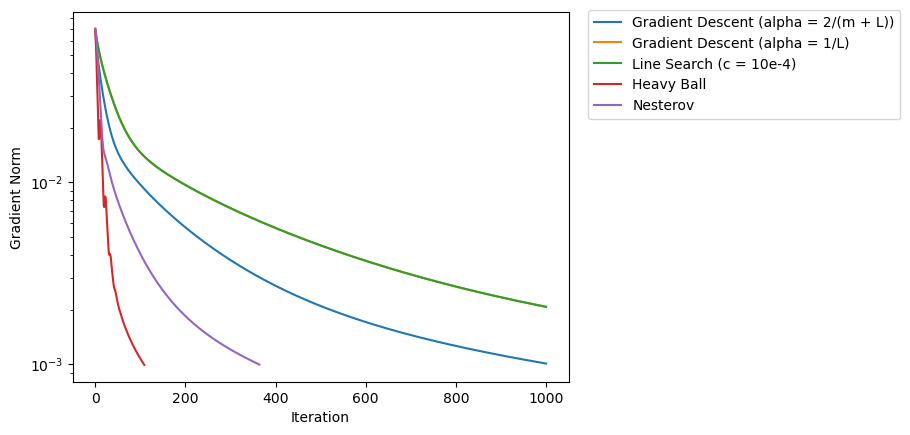

In [46]:
# initialize output plot
plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')

for g_method, method in zip(g_methods, methods):
    plt.semilogy(g_method, label=method)

plt.legend(bbox_to_anchor=(1.025, 1.025), loc='upper left')
plt.show()

In [47]:
# compute average number of iterations over various random initializations
output = [[] for _ in methods]

for i in range(19):

    # create random initialization (x0/x_null)
    x_null = np.random.randn(n)

    # gradient descent
    alpha_convex = 2 / (m + L)
    _, _, T_convex = gradient_descent_fixed(
        x_null, lambda x, y: quadfun(x, y, A, b),
        alpha_convex,
        epsilon, max_iter
    )
    output[0].append(T_convex)

    _, _, T_fixed = gradient_descent_fixed(
        x_null, lambda x, y: quadfun(x, y, A, b),
        alpha,
        epsilon, max_iter
    )
    output[1].append(T_fixed)

    # backtracking line search
    line_search_c = 10e-4
    line_search_rho = 0.5
    _, _, T_line_search = gradient_descent_line_search(
        x_null, lambda x, y: quadfun(x, y, A, b),
        alpha, line_search_c, line_search_rho,
        epsilon, max_iter
    )
    output[2].append(T_line_search)

    # accelerated gradient method
    alpha_acc = 4 / ((np.sqrt(L) + np.sqrt(m)) ** 2)
    beta_acc = (np.sqrt(L) - np.sqrt(m)) / (np.sqrt(L) + np.sqrt(m))

    _, _, T_heavy = gradient_descent_heavy_ball(
        x_null, lambda x, y: quadfun(x, y, A, b),
        alpha_acc, beta_acc,
        epsilon, max_iter
    )
    output[3].append(T_heavy)

    _, _, T_nesterov = gradient_descent_nesterov(
        x_null, lambda x, y: quadfun(x, y, A, b),
        1/L, beta_acc,
        epsilon, max_iter
    )
    output[4].append(T_nesterov)


In [48]:
for i, method in enumerate(methods):
    print(method, f'\n\t Avg Iterations Till Termination: {np.mean(output[i]):.2f}')

Gradient Descent (alpha = 2/(m + L)) 
	 Avg Iterations Till Termination: 966.89
Gradient Descent (alpha = 1/L) 
	 Avg Iterations Till Termination: 1000.00
Line Search (c = 10e-4) 
	 Avg Iterations Till Termination: 1000.00
Heavy Ball 
	 Avg Iterations Till Termination: 108.58
Nesterov 
	 Avg Iterations Till Termination: 364.37


#### Question 2 Part C

Below is code to generate a contour plot (each point on a curve in the plot has the same function value; minimum is at (0,0)) of the 2-d quadratic function $\frac12 x^T A x$ with $A = \left[\begin{matrix}0.25 & 0 \\ 0 & 1\end{matrix}\right]$. The iterates of gradient descent are plotted. Plot the iterates of Nesterov's Accelerated Gradient based on the homework PDF's specifications and compare.


Feel free to play around with the parameter settings - we can observe some relatively crazy behavior from momentum methods when the momentum parameter becomes close to 1 (which is the standard when training deep learning models!).

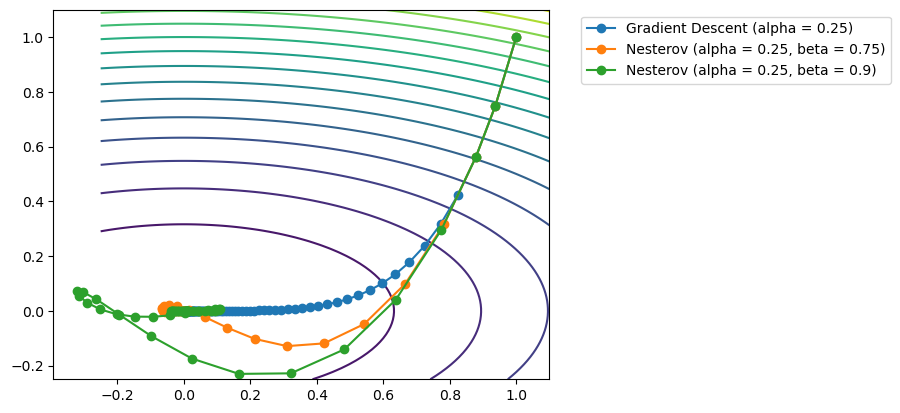

In [49]:
# Define the function, makes it easier to generate contour plot
def func(x1, x2):
    return (1/2)*x2**2 + (1/2)*0.25*x1**2

# Generate a grid of x1 and x2 values
x1 = np.linspace(-0.25, 1.1, 100)
x2 = np.linspace(-0.25, 1.1, 100)
x1_grid, x2_grid = np.meshgrid(x1, x2)

# Evaluate the function on the grid
z = func(x1_grid, x2_grid)

# Plot the contour plot of the function in black and white
plt.contour(x1_grid, x2_grid, z, levels=15)


# Initialize the starting point
x0 = np.array([1, 1])
# A defined for use with quadfun
A = np.array([[0.25, 0.0], [0.0, 1.0]])
b = np.array([0.0, 0.0])

# Perform gradient descent
alpha = 0.25
epsilon = 10**-4
max_iter = 100
x_gd, g_gd, i_gd = gradient_descent_fixed(x0, lambda x, y: quadfun(x, y, A, b), alpha, epsilon, max_iter)

# Plot the iterates of gradient descent on the same plot
iterates = np.array(x_gd)
plt.plot(iterates[0:len(iterates)-1, 0], iterates[0:len(iterates)-1, 1], '-o')
labels = [f'Gradient Descent (alpha = {alpha})']

# nesterov accelerated gradient
alpha_nesterov = 0.25
beta_nesterov = 0.75
x_nesterov, _, _ = gradient_descent_nesterov(x0, lambda x, y: quadfun(x, y, A, b), alpha_nesterov, beta_nesterov, epsilon, max_iter)
iterates_nesterov = np.array(x_nesterov)
plt.plot(iterates_nesterov[0:len(iterates_nesterov)-1, 0], iterates_nesterov[0:len(iterates_nesterov)-1, 1], '-o')
labels.append(f'Nesterov (alpha = {alpha_nesterov}, beta = {beta_nesterov})')

alpha_nesterov2 = 0.25
beta_nesterov2 = 0.9
x_nesterov2, _, _ = gradient_descent_nesterov(x0, lambda x, y: quadfun(x, y, A, b), alpha_nesterov2, beta_nesterov2, epsilon, max_iter)
iterates_nesterov2 = np.array(x_nesterov2)
plt.plot(iterates_nesterov2[0:len(iterates_nesterov2)-1, 0], iterates_nesterov2[0:len(iterates_nesterov2)-1, 1], '-o')
labels.append(f'Nesterov (alpha = {alpha_nesterov2}, beta = {beta_nesterov2})')

plt.legend(labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()